# Word Level Federated Text Generation with Stack Overflow
- Joel Stremmel
- 02-01-20

**About:**

This notebook loads the Stack Overflow data available through `tff.simulation.datasets` and trains an LSTM model with Federared Averaging by following the Federated Learning for Text Generation [example notebook](https://github.com/tensorflow/federated/blob/master/docs/tutorials/federated_learning_for_text_generation.ipynb).  The embedding layer is initialized using pretrained GloVe embeddings from the Stanford NLP group.

**Notes:**

- This notebook prepares the Stack Overflow dataset for word level language modeling using this [module](https://github.com/tensorflow/federated/blob/master/tensorflow_federated/python/research/baselines/stackoverflow/dataset.py
).
- The metrics for model training come from this [module](https://github.com/tensorflow/federated/blob/master/tensorflow_federated/python/research/baselines/stackoverflow/metrics.py). 


**Data:** 
- https://www.kaggle.com/stackoverflow/stackoverflow
- https://nlp.stanford.edu/projects/glove/

**License:** 
- https://creativecommons.org/licenses/by-sa/3.0/
- https://opendatacommons.org/licenses/pddl/

**Data and Model References:**
- https://www.tensorflow.org/federated/api_docs/python/tff/simulation/datasets/stackoverflow/load_data
- https://github.com/tensorflow/federated/blob/master/docs/tutorials/federated_learning_for_text_generation.ipynb
- https://github.com/tensorflow/federated/tree/master/tensorflow_federated/python/research/baselines/stackoverflow
- https://www.tensorflow.org/tutorials/text/text_generation

**Environment Setup References:**
- https://www.tensorflow.org/install/gpu
- https://gist.github.com/matheustguimaraes/43e0b65aa534db4df2918f835b9b361d
- https://www.tensorflow.org/install/source#tested_build_configurations
- https://anbasile.github.io/programming/2017/06/25/jupyter-venv/

### Environment Setup
Pip install these packages in the order listed.

In [1]:
# !pip install --upgrade pip
# !pip install --upgrade tensorflow-federated
# !pip uninstall tensorflow -y
# !pip install --upgrade tensorflow-gpu==2.0
# !pip install --upgrade nltk
# !pip install matplotlib
# !pip install nest_asyncio

### Imports

In [2]:
import nest_asyncio
nest_asyncio.apply()

In [3]:
import os, sys
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))

In [4]:
# from https://github.com/tensorflow/federated/blob/master/tensorflow_federated/python/research/baselines/stackoverflow/dataset.py
from utils.dataset import construct_word_level_datasets, get_vocab, get_special_tokens

# from https://github.com/tensorflow/federated/blob/master/tensorflow_federated/python/research/baselines/stackoverflow/metrics.py
import utils.metrics as metrics

In [5]:
import collections
import functools
import six
import time
import string

import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

import tensorflow as tf
import tensorflow_federated as tff

### Set Compatability Behavior

In [6]:
tf.compat.v1.enable_v2_behavior()

### Check Tensorflow Install

In [7]:
print('Built with Cuda: {}'.format(tf.test.is_built_with_cuda()))
print('Build with GPU support: {}'.format(tf.test.is_built_with_gpu_support()))
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Built with Cuda: True
Build with GPU support: True
Num GPUs Available:  1


### Set Tensorflow to Use GPU

In [8]:
physical_devices = tf.config.experimental.list_physical_devices(device_type=None)
tf.config.experimental.set_memory_growth(physical_devices[-1], enable=True)
for device in physical_devices:
    print(device)

PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU')
PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


### Test TFF

In [9]:
tff.federated_computation(lambda: 'Hello, World!')()

'Hello, World!'

### Set Some Parameters for Preprocessing the Data and Training the Model
**Note:** Ask Keith how he's been setting there for internal experiments.

In [10]:
VOCAB_SIZE = 10000
BATCH_SIZE = 8
CLIENTS_EPOCHS_PER_ROUND = 1
MAX_SEQ_LENGTH = 20
MAX_ELEMENTS_PER_USER = 500
CENTRALIZED_TRAIN = False
SHUFFLE_BUFFER_SIZE = 1000
NUM_VALIDATION_EXAMPLES = 10000
NUM_TEST_EXAMPLES = 2

NUM_ROUNDS = 100
NUM_TRAIN_CLIENTS = 10
UNIFORM_WEIGHTING = False

EMBEDDING_DIM = 100
EMBEDDING_PATH = f'/home/joel_stremmel/word_embeddings/glove.6B.{EMBEDDING_DIM}d.txt'
RNN_UNITS = 256

### Load and Preprocess Word Level Datasets

In [11]:
train_data, val_data, test_data = construct_word_level_datasets(
    vocab_size=VOCAB_SIZE,
    batch_size=BATCH_SIZE,
    client_epochs_per_round=CLIENTS_EPOCHS_PER_ROUND,
    max_seq_len=MAX_SEQ_LENGTH,
    max_elements_per_user=MAX_ELEMENTS_PER_USER,
    centralized_train=CENTRALIZED_TRAIN,
    shuffle_buffer_size=SHUFFLE_BUFFER_SIZE,
    num_validation_examples=NUM_VALIDATION_EXAMPLES,
    num_test_examples=NUM_TEST_EXAMPLES)

/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


### Retrieve the Dataset Vocab

In [12]:
vocab = get_vocab(VOCAB_SIZE)

### Retrieve the Special Characters Created During Preprocessing
The four special tokens are:
- pad: padding token
- oov: out of vocabulary
- bos: begin of sentence
- eos: end of sentence

In [13]:
pad, oov, bos, eos = get_special_tokens(VOCAB_SIZE)

In [14]:
special2idx = dict(zip(['pad', 'oov', 'bos', 'eos'], [pad, oov, bos, eos]))
idx2special = {v:k for k, v in special2idx.items()}

### Set Vocabulary
Add one to account for the pad token which has idx 0.

In [15]:
word2idx = {word:i+1 for i, word in enumerate(vocab)}
idx2word = {i+1:word for i, word in enumerate(vocab)}

### Add Special Characters

In [16]:
word2idx = {**word2idx, **special2idx}
idx2word = {**idx2word, **idx2special}

### Reset Vocab Size
This accounts for having added the special characters.

In [17]:
EXTENDED_VOCAB_SIZE = VOCAB_SIZE + len(special2idx)

### Load Pretrained Word Embeddings
- [GloVe embeddings](https://nlp.stanford.edu/projects/glove/) trained on Wikipedia
- [Example usage](https://github.com/keras-team/keras/blob/master/examples/pretrained_word_embeddings.py)

In [18]:
def load_pretrained_embeddings():
    
    embeddings_index = {}
    with open(EMBEDDING_PATH, 'r') as f:
        for line in f:
            word, coefs = line.split(maxsplit=1)
            coefs = np.fromstring(coefs, 'f', sep=' ')
            embeddings_index[word] = coefs
            
    return embeddings_index

### Create Embedding Matrix from Words in Word Index and Word Embeddings
Words with no embedding are initialized as a vector of zeros.

In [19]:
def create_matrix_from_pretrained_embeddings():
    
    embeddings_index = load_pretrained_embeddings()
    embedding_matrix = np.zeros((EXTENDED_VOCAB_SIZE, EMBEDDING_DIM))

    for word, i in word2idx.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    
    return embedding_matrix

In [20]:
m = create_matrix_from_pretrained_embeddings()
missing_words = np.sum(~m.any(axis=1))
print(f'Words from dataset with no embedding: {missing_words}')

Words from dataset with no embedding: 1304


### Create Embedding Initializer

In [21]:
def initialize_embedding():
    
    embedding_matrix = create_matrix_from_pretrained_embeddings()
    
    return tf.keras.initializers.Constant(embedding_matrix)

### Define Function to Build Model

In [22]:
def build_model():
    """
    Build model with architecture from: https://www.tensorflow.org/tutorials/text/text_generation.
    """

    model1_input = tf.keras.Input(shape=(None, ), # changed from MAX_SEQ_LENGTH
                                  name='model1_input')
    
    model1_embedding = tf.keras.layers.Embedding(input_dim=EXTENDED_VOCAB_SIZE,
                                                 output_dim=EMBEDDING_DIM,
                                                 embeddings_initializer=initialize_embedding(), 
                                                 mask_zero=True,
                                                 trainable=True, # try unfreezing partway through training
                                                 name='model1_embedding')(model1_input)
    
    model1_lstm = tf.keras.layers.LSTM(units=RNN_UNITS,
                                       return_sequences=True,
                                       recurrent_initializer='glorot_uniform',
                                       name='model1_lstm')(model1_embedding)
    
    model1_dense1 = tf.keras.layers.Dense(units=EMBEDDING_DIM)(model1_lstm)
    
    model1_dense2 = tf.keras.layers.Dense(units=EXTENDED_VOCAB_SIZE)(model1_dense1)
    
    final_model = tf.keras.Model(inputs=model1_input, outputs=model1_dense2)
                 
    return final_model

### Define the Text Generation Strategy

In [23]:
def generate_text(model, start_string):
    """
    Generate text by sampling from the model output distribution
    as in From https://www.tensorflow.org/tutorials/sequences/text_generation.
    """
    
    start_words = [word.lower() for word in start_string.split(' ')]

    num_generate = 50
    input_eval = [word2idx[word] for word in start_words]
    input_eval = tf.expand_dims(input_eval, 0)
    text_generated = []
    temperature = 1.0

    model.reset_states()
    for i in range(num_generate):
        predictions = model(input_eval)
        predictions = tf.squeeze(predictions, 0)
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1, 0].numpy()
        input_eval = tf.expand_dims([predicted_id], 0)
        text_generated.append(idx2word[predicted_id])

    return (' '.join(start_words) + ' '.join(text_generated))

### Load or Build the Model and Try Generating Some Text

In [24]:
keras_model = build_model()
print(generate_text(keras_model, "How are you today"))

how are you todaydeprecated postgresql raw pow injected ado neighbor exited keyboard matt switched afraid disallowed courtesy bower minute describe averages sizeof separate s1 onclick datastore compilation where instantiating optimistic up-to-date hide backtracking drawer white-space reproducible love forever saves times list's dbo fires willing classa ls sans background-color you've post_id dictates journal uiimage


### Define Evaluation Metrics for Training

In [25]:
def get_metrics():
    
    evaluation_metrics = [
        metrics.NumTokensCounter(name='num_tokens', masked_tokens=[pad]),
        metrics.NumTokensCounter(name='num_tokens_no_oov', masked_tokens=[pad, oov]),
        metrics.NumBatchesCounter(name='num_batches'),
        metrics.NumExamplesCounter(name='num_examples'),
        metrics.MaskedCategoricalAccuracy(name='accuracy', masked_tokens=[pad]),
        metrics.MaskedCategoricalAccuracy(name='accuracy_no_oov', masked_tokens=[pad, oov]),
        metrics.MaskedCategoricalAccuracy(name='accuracy_no_oov_no_eos', masked_tokens=[pad, oov, eos])
    ]
    
    return evaluation_metrics

### Define a Function to Compile the Model for Training

In [26]:
def compile_model(keras_model, evaluation_metrics):
    
    keras_model.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer=tf.keras.optimizers.Adam(),
        metrics=evaluation_metrics)
    
    return keras_model

### Create TFF Version of the Model to be Trained with Federated Averaging
- TFF uses a sample batch so it knows the types and shapes that your model expects.
- The model function then builds and compiles the model and creates a TFF version to be trained.

In [27]:
sample_batch = tf.nest.map_structure(lambda x: x.numpy(), next(iter(val_data)))

/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


In [28]:
def model_fn():
    """
    Create TFF model from compiled Keras model and a sample batch.
    """
    
    keras_model = build_model()
    evaluation_metrics = get_metrics()
    
    compile_model(keras_model, evaluation_metrics)
    
    return tff.learning.from_compiled_keras_model(keras_model, sample_batch)

### Define Model History Tracker to Save Metrics at Each Training Round
This is a spin off of [keras' model history](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History) but is specific to the TFF training code used here.

In [29]:
class model_history_tracker:
    
    def __init__(self, metric_names=[]):
        
        self.metric_names = metric_names
        self.metrics_dict = {name:[] for name in metric_names}
    
    def get_metrics_by_name(self, metric_name):
        
        return self.metrics_dict[metric_name]
    
    def add_metrics_by_name(self, metric_name, metric_result):
        
        self.metrics_dict[metric_name].append(metric_result) 

### Initialize Train and Validation Model Trackers to be Used Below

In [30]:
evaluation_metric_names = ['loss',
                           'num_tokens',
                           'num_tokens_no_oov',
                           'num_batches',
                           'num_examples',
                           'accuracy',
                           'accuracy_no_oov',
                           'accuracy_no_oov_no_oes']

train_metrics_tracker = model_history_tracker(evaluation_metric_names)
val_metrics_tracker = model_history_tracker(evaluation_metric_names)

### Define Function to Evaluate Model Performance on Validation Data

In [31]:
def keras_evaluate(state, val_dataset):
    
    keras_model = build_model()
    evaluation_metrics = get_metrics()
    
    compile_model(keras_model, evaluation_metrics)
    tff.learning.assign_weights_to_keras_model(keras_model, state.model)
    
    evaluation_results = keras_model.evaluate(val_dataset)
    
    for i, result in enumerate(evaluation_results):
        val_metrics_tracker.add_metrics_by_name(val_metrics_tracker.metric_names[i], result)

### Define Function to Weight Clients Uniformly or by Number of Tokens

In [32]:
def client_weight_fn(local_outputs):
    
    num_tokens = tf.cast(tf.squeeze(local_outputs['num_tokens']), tf.float32)
    
    return 1.0 if UNIFORM_WEIGHTING else num_tokens

### Define Function to Supply Server Optimizer

In [33]:
def server_optimizer_fn():
    
    return tf.keras.optimizers.Adam()

### Set the Default Executor

In [34]:
tff.framework.set_default_executor(tff.framework.create_local_executor(max_fanout=10))

### Create an Iterative Process

In [35]:
iterative_process = (
      tff.learning.federated_averaging.build_federated_averaging_process(
          model_fn=model_fn,
          server_optimizer_fn=server_optimizer_fn,
          client_weight_fn=client_weight_fn))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


### Initalize the Process
Server state will be updated in the training loop.

In [36]:
server_state = iterative_process.initialize()

### Define Function to Create Training Datsets from Randomly Sampled Clients

In [37]:
def get_sample_clients(dataset, num_clients):
    
    random_indices = np.random.choice(len(dataset.client_ids), size=num_clients, replace=False)
    
    return np.array(dataset.client_ids)[random_indices]

### Train Model Across Many Randomly Sampled Clients with Federated Averaging

In [38]:
%time
for round_num in range(0, NUM_ROUNDS):
    
    # Examine validation metrics
    print(f'Evaluating before training round #{round_num} on {NUM_VALIDATION_EXAMPLES} examples.')
    keras_evaluate(server_state, val_data)
    
    # Sample train clients to create a train dataset
    print(f'Sampling {NUM_TRAIN_CLIENTS} new clients.')
    train_clients = get_sample_clients(train_data, num_clients=NUM_TRAIN_CLIENTS)
    train_datasets = [train_data.create_tf_dataset_for_client(client) for client in train_clients]
    
    # Apply federated training round
    server_state, server_metrics = iterative_process.next(server_state, train_datasets)
    
    # Examine training metrics
    print('Round: {}'.format(round_num))
    print('   Loss: {:.8f}'.format(server_metrics.loss))
    print('   num_batches: {}'.format(server_metrics.num_batches))
    print('   num_examples: {}'.format(server_metrics.num_examples))
    print('   num_tokens: {}'.format(server_metrics.num_tokens))
    print('   num_tokens_no_oov: {}'.format(server_metrics.num_tokens_no_oov))
    print('   accuracy: {:.5f}'.format(server_metrics.accuracy))
    print('   accuracy_no_oov: {:.5f}'.format(server_metrics.accuracy_no_oov))
    
    # Add train metrics to tracker
    train_metrics_tracker.add_metrics_by_name('loss', server_metrics.loss)
    train_metrics_tracker.add_metrics_by_name('accuracy', server_metrics.accuracy)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 10.7 µs
Evaluating before training round #0 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 18s 181ms/step - loss: 6.4281 - num_tokens: 132474.0000 - num_tokens_no_oov: 128122.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 2.2646e-05 - accuracy_no_oov: 2.3415e-05 - accuracy_no_oov_no_eos: 2.4834e-05
Sampling 10 new clients.
Round: 0
   Loss: 6.09910822
   num_batches: 302
   num_examples: 2385
   num_tokens: 29935
   num_tokens_no_oov: 29210
   accuracy: 0.00555
   accuracy_no_oov: 0.00568
Evaluating before training round #1 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 18s 180ms/step - loss: 6.2311 - num_tokens: 128243.0000 - num_tokens_no_oov: 124076.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 2.7292e-04 - accuracy_no_oov: 2.8209e-04 - accuracy_no_oov_no_eos: 3.0028e-04
Sampling 10 new clients.
Round: 1
   Loss: 6.34348297
   num_batches: 242
   num_examples: 1898
   num_tokens: 25334
   num_tokens_no_oov: 24666
   accuracy: 0.00067
   accuracy_no_oov: 0.00069
Evaluating before training round #2 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 19s 188ms/step - loss: 6.3658 - num_tokens: 131633.0000 - num_tokens_no_oov: 127708.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 3.9504e-04 - accuracy_no_oov: 4.0718e-04 - accuracy_no_oov_no_eos: 4.3252e-04
Sampling 10 new clients.
Round: 2
   Loss: 5.53969574
   num_batches: 353
   num_examples: 2788
   num_tokens: 36180
   num_tokens_no_oov: 35299
   accuracy: 0.00122
   accuracy_no_oov: 0.00125
Evaluating before training round #3 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 18s 179ms/step - loss: 6.2465 - num_tokens: 129745.0000 - num_tokens_no_oov: 125786.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 3.0830e-05 - accuracy_no_oov: 3.1800e-05 - accuracy_no_oov_no_eos: 3.3817e-05
Sampling 10 new clients.
Round: 3
   Loss: 5.26058865
   num_batches: 330
   num_examples: 2604
   num_tokens: 32610
   num_tokens_no_oov: 31666
   accuracy: 0.00080
   accuracy_no_oov: 0.00082
Evaluating before training round #4 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 19s 186ms/step - loss: 6.2398 - num_tokens: 131232.0000 - num_tokens_no_oov: 127228.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 4
   Loss: 4.99929142
   num_batches: 451
   num_examples: 3567
   num_tokens: 47125
   num_tokens_no_oov: 45567
   accuracy: 0.00361
   accuracy_no_oov: 0.00373
Evaluating before training round #5 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 18s 182ms/step - loss: 6.1789 - num_tokens: 132917.0000 - num_tokens_no_oov: 128536.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 5
   Loss: 5.30979729
   num_batches: 341
   num_examples: 2691
   num_tokens: 37203
   num_tokens_no_oov: 36224
   accuracy: 0.00344
   accuracy_no_oov: 0.00353
Evaluating before training round #6 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 19s 185ms/step - loss: 6.0249 - num_tokens: 133672.0000 - num_tokens_no_oov: 129642.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 6
   Loss: 4.73525715
   num_batches: 343
   num_examples: 2704
   num_tokens: 33470
   num_tokens_no_oov: 32503
   accuracy: 0.00592
   accuracy_no_oov: 0.00609
Evaluating before training round #7 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 19s 189ms/step - loss: 5.9679 - num_tokens: 137009.0000 - num_tokens_no_oov: 132567.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 7
   Loss: 4.81147385
   num_batches: 266
   num_examples: 2109
   num_tokens: 26297
   num_tokens_no_oov: 25683
   accuracy: 0.00380
   accuracy_no_oov: 0.00389
Evaluating before training round #8 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 19s 186ms/step - loss: 5.5296 - num_tokens: 130693.0000 - num_tokens_no_oov: 125998.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 8
   Loss: 4.92129326
   num_batches: 356
   num_examples: 2809
   num_tokens: 39007
   num_tokens_no_oov: 38100
   accuracy: 0.00938
   accuracy_no_oov: 0.00961
Evaluating before training round #9 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 19s 189ms/step - loss: 5.2522 - num_tokens: 127906.0000 - num_tokens_no_oov: 123852.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 9
   Loss: 4.60718918
   num_batches: 214
   num_examples: 1682
   num_tokens: 20678
   num_tokens_no_oov: 19990
   accuracy: 0.00314
   accuracy_no_oov: 0.00325
Evaluating before training round #10 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 21s 205ms/step - loss: 5.1019 - num_tokens: 128621.0000 - num_tokens_no_oov: 124252.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 10
   Loss: 4.50959921
   num_batches: 270
   num_examples: 2120
   num_tokens: 27074
   num_tokens_no_oov: 26334
   accuracy: 0.00672
   accuracy_no_oov: 0.00691
Evaluating before training round #11 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 19s 187ms/step - loss: 4.9882 - num_tokens: 129759.0000 - num_tokens_no_oov: 125984.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 11
   Loss: 4.31214190
   num_batches: 362
   num_examples: 2860
   num_tokens: 36759
   num_tokens_no_oov: 35839
   accuracy: 0.01540
   accuracy_no_oov: 0.01579
Evaluating before training round #12 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 19s 186ms/step - loss: 4.8857 - num_tokens: 131103.0000 - num_tokens_no_oov: 126647.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 12
   Loss: 4.38098335
   num_batches: 431
   num_examples: 3418
   num_tokens: 45497
   num_tokens_no_oov: 43955
   accuracy: 0.02139
   accuracy_no_oov: 0.02189
Evaluating before training round #13 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 21s 205ms/step - loss: 4.9149 - num_tokens: 134644.0000 - num_tokens_no_oov: 130113.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 13
   Loss: 4.27982712
   num_batches: 303
   num_examples: 2382
   num_tokens: 30811
   num_tokens_no_oov: 29569
   accuracy: 0.01396
   accuracy_no_oov: 0.01447
Evaluating before training round #14 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 19s 189ms/step - loss: 4.7862 - num_tokens: 133638.0000 - num_tokens_no_oov: 129298.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 14
   Loss: 4.63106823
   num_batches: 331
   num_examples: 2619
   num_tokens: 37449
   num_tokens_no_oov: 36371
   accuracy: 0.02096
   accuracy_no_oov: 0.01771
Evaluating before training round #15 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 19s 191ms/step - loss: 4.6939 - num_tokens: 132567.0000 - num_tokens_no_oov: 128062.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 15
   Loss: 4.28788567
   num_batches: 306
   num_examples: 2408
   num_tokens: 31718
   num_tokens_no_oov: 30721
   accuracy: 0.02223
   accuracy_no_oov: 0.02295
Evaluating before training round #16 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 21s 211ms/step - loss: 4.5078 - num_tokens: 129250.0000 - num_tokens_no_oov: 125559.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 16
   Loss: 4.00828457
   num_batches: 332
   num_examples: 2610
   num_tokens: 32661
   num_tokens_no_oov: 31645
   accuracy: 0.03233
   accuracy_no_oov: 0.03337
Evaluating before training round #17 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 19s 186ms/step - loss: 4.7117 - num_tokens: 135624.0000 - num_tokens_no_oov: 131687.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 17
   Loss: 3.98150277
   num_batches: 360
   num_examples: 2852
   num_tokens: 35747
   num_tokens_no_oov: 34709
   accuracy: 0.03637
   accuracy_no_oov: 0.03745
Evaluating before training round #18 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 19s 186ms/step - loss: 4.5068 - num_tokens: 130806.0000 - num_tokens_no_oov: 126415.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 18
   Loss: 3.99047112
   num_batches: 268
   num_examples: 2111
   num_tokens: 26695
   num_tokens_no_oov: 25968
   accuracy: 0.03795
   accuracy_no_oov: 0.03901
Evaluating before training round #19 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 18s 182ms/step - loss: 4.4582 - num_tokens: 130321.0000 - num_tokens_no_oov: 126156.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 19
   Loss: 4.28255272
   num_batches: 276
   num_examples: 2166
   num_tokens: 29196
   num_tokens_no_oov: 28057
   accuracy: 0.03668
   accuracy_no_oov: 0.03140
Evaluating before training round #20 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 19s 186ms/step - loss: 4.7161 - num_tokens: 138315.0000 - num_tokens_no_oov: 133440.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 20
   Loss: 4.40456486
   num_batches: 418
   num_examples: 3295
   num_tokens: 46655
   num_tokens_no_oov: 45186
   accuracy: 0.04730
   accuracy_no_oov: 0.03972
Evaluating before training round #21 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 19s 185ms/step - loss: 4.4747 - num_tokens: 132418.0000 - num_tokens_no_oov: 128212.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0026 - accuracy_no_oov: 0.0027 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 21
   Loss: 4.12281036
   num_batches: 234
   num_examples: 1847
   num_tokens: 23792
   num_tokens_no_oov: 23268
   accuracy: 0.04069
   accuracy_no_oov: 0.04160
Evaluating before training round #22 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 21s 214ms/step - loss: 4.3886 - num_tokens: 130642.0000 - num_tokens_no_oov: 126538.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0460 - accuracy_no_oov: 0.0475 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 22
   Loss: 4.10392475
   num_batches: 394
   num_examples: 3111
   num_tokens: 40899
   num_tokens_no_oov: 39564
   accuracy: 0.05274
   accuracy_no_oov: 0.05338
Evaluating before training round #23 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 18s 185ms/step - loss: 4.6041 - num_tokens: 136393.0000 - num_tokens_no_oov: 131887.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0475 - accuracy_no_oov: 0.0491 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 23
   Loss: 4.40659618
   num_batches: 337
   num_examples: 2653
   num_tokens: 37409
   num_tokens_no_oov: 36260
   accuracy: 0.05012
   accuracy_no_oov: 0.05171
Evaluating before training round #24 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 18s 180ms/step - loss: 4.4300 - num_tokens: 132502.0000 - num_tokens_no_oov: 128381.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0523 - accuracy_no_oov: 0.0540 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 24
   Loss: 4.25263453
   num_batches: 239
   num_examples: 1877
   num_tokens: 24948
   num_tokens_no_oov: 24273
   accuracy: 0.05379
   accuracy_no_oov: 0.05529
Evaluating before training round #25 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 18s 179ms/step - loss: 4.4798 - num_tokens: 134150.0000 - num_tokens_no_oov: 129849.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0526 - accuracy_no_oov: 0.0544 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 25
   Loss: 4.35111475
   num_batches: 306
   num_examples: 2413
   num_tokens: 33493
   num_tokens_no_oov: 32457
   accuracy: 0.05667
   accuracy_no_oov: 0.05814
Evaluating before training round #26 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 18s 182ms/step - loss: 4.5361 - num_tokens: 136050.0000 - num_tokens_no_oov: 131595.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0516 - accuracy_no_oov: 0.0533 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 26
   Loss: 3.95816636
   num_batches: 397
   num_examples: 3133
   num_tokens: 40863
   num_tokens_no_oov: 39593
   accuracy: 0.06441
   accuracy_no_oov: 0.06648
Evaluating before training round #27 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 19s 186ms/step - loss: 4.3700 - num_tokens: 130876.0000 - num_tokens_no_oov: 126782.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0550 - accuracy_no_oov: 0.0568 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 27
   Loss: 4.49673128
   num_batches: 277
   num_examples: 2179
   num_tokens: 31179
   num_tokens_no_oov: 30212
   accuracy: 0.05109
   accuracy_no_oov: 0.05028
Evaluating before training round #28 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 20s 204ms/step - loss: 4.3728 - num_tokens: 131484.0000 - num_tokens_no_oov: 127697.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0549 - accuracy_no_oov: 0.0566 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 28
   Loss: 4.11070061
   num_batches: 271
   num_examples: 2125
   num_tokens: 28565
   num_tokens_no_oov: 27824
   accuracy: 0.06203
   accuracy_no_oov: 0.06254
Evaluating before training round #29 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 18s 184ms/step - loss: 4.3619 - num_tokens: 131385.0000 - num_tokens_no_oov: 127293.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0565 - accuracy_no_oov: 0.0583 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 29
   Loss: 4.09051418
   num_batches: 201
   num_examples: 1581
   num_tokens: 21203
   num_tokens_no_oov: 20147
   accuracy: 0.07291
   accuracy_no_oov: 0.05782
Evaluating before training round #30 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 19s 189ms/step - loss: 4.3525 - num_tokens: 130735.0000 - num_tokens_no_oov: 126586.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0573 - accuracy_no_oov: 0.0592 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 30
   Loss: 3.81138921
   num_batches: 323
   num_examples: 2540
   num_tokens: 32073
   num_tokens_no_oov: 30800
   accuracy: 0.07361
   accuracy_no_oov: 0.07269
Evaluating before training round #31 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 19s 186ms/step - loss: 4.2874 - num_tokens: 127777.0000 - num_tokens_no_oov: 124112.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0580 - accuracy_no_oov: 0.0597 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 31
   Loss: 3.88937521
   num_batches: 312
   num_examples: 2452
   num_tokens: 30864
   num_tokens_no_oov: 29850
   accuracy: 0.07718
   accuracy_no_oov: 0.07980
Evaluating before training round #32 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 22s 221ms/step - loss: 4.5265 - num_tokens: 135551.0000 - num_tokens_no_oov: 131274.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0531 - accuracy_no_oov: 0.0549 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 32
   Loss: 4.04896307
   num_batches: 339
   num_examples: 2681
   num_tokens: 35242
   num_tokens_no_oov: 33999
   accuracy: 0.06563
   accuracy_no_oov: 0.06444
Evaluating before training round #33 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 19s 188ms/step - loss: 4.3716 - num_tokens: 130951.0000 - num_tokens_no_oov: 126630.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0570 - accuracy_no_oov: 0.0590 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 33
   Loss: 4.21908045
   num_batches: 273
   num_examples: 2147
   num_tokens: 28871
   num_tokens_no_oov: 28142
   accuracy: 0.06720
   accuracy_no_oov: 0.06894
Evaluating before training round #34 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 18s 182ms/step - loss: 4.3340 - num_tokens: 129443.0000 - num_tokens_no_oov: 125364.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0574 - accuracy_no_oov: 0.0593 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 34
   Loss: 3.87176538
   num_batches: 384
   num_examples: 3030
   num_tokens: 38736
   num_tokens_no_oov: 37426
   accuracy: 0.07654
   accuracy_no_oov: 0.07917
Evaluating before training round #35 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 19s 190ms/step - loss: 4.5366 - num_tokens: 134379.0000 - num_tokens_no_oov: 130200.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0540 - accuracy_no_oov: 0.0557 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 35
   Loss: 3.92459702
   num_batches: 213
   num_examples: 1670
   num_tokens: 21481
   num_tokens_no_oov: 20880
   accuracy: 0.07895
   accuracy_no_oov: 0.08123
Evaluating before training round #36 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 18s 185ms/step - loss: 4.3965 - num_tokens: 131190.0000 - num_tokens_no_oov: 126743.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0569 - accuracy_no_oov: 0.0589 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 36
   Loss: 3.93022037
   num_batches: 291
   num_examples: 2302
   num_tokens: 29665
   num_tokens_no_oov: 28764
   accuracy: 0.08188
   accuracy_no_oov: 0.08389
Evaluating before training round #37 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 23s 232ms/step - loss: 4.6010 - num_tokens: 136045.0000 - num_tokens_no_oov: 131979.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0517 - accuracy_no_oov: 0.0533 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 37
   Loss: 4.32317019
   num_batches: 239
   num_examples: 1874
   num_tokens: 26050
   num_tokens_no_oov: 25292
   accuracy: 0.07489
   accuracy_no_oov: 0.07587
Evaluating before training round #38 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 20s 199ms/step - loss: 4.4144 - num_tokens: 131123.0000 - num_tokens_no_oov: 127044.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0555 - accuracy_no_oov: 0.0573 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 38
   Loss: 4.04186726
   num_batches: 286
   num_examples: 2248
   num_tokens: 29574
   num_tokens_no_oov: 28790
   accuracy: 0.06739
   accuracy_no_oov: 0.06909
Evaluating before training round #39 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 19s 191ms/step - loss: 4.7335 - num_tokens: 139377.0000 - num_tokens_no_oov: 135199.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0492 - accuracy_no_oov: 0.0507 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 39
   Loss: 3.73498106
   num_batches: 322
   num_examples: 2554
   num_tokens: 31525
   num_tokens_no_oov: 30610
   accuracy: 0.08022
   accuracy_no_oov: 0.08174
Evaluating before training round #40 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 19s 185ms/step - loss: 4.3585 - num_tokens: 129433.0000 - num_tokens_no_oov: 125423.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0580 - accuracy_no_oov: 0.0599 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 40
   Loss: 3.83121538
   num_batches: 179
   num_examples: 1403
   num_tokens: 17149
   num_tokens_no_oov: 16622
   accuracy: 0.08245
   accuracy_no_oov: 0.08507
Evaluating before training round #41 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 18s 183ms/step - loss: 4.4693 - num_tokens: 132574.0000 - num_tokens_no_oov: 128579.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0556 - accuracy_no_oov: 0.0573 - accuracy_no_oov_no_eos: 8.2498e-06
Sampling 10 new clients.
Round: 41
   Loss: 4.15340757
   num_batches: 244
   num_examples: 1908
   num_tokens: 25537
   num_tokens_no_oov: 24860
   accuracy: 0.08090
   accuracy_no_oov: 0.08270
Evaluating before training round #42 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 19s 191ms/step - loss: 4.4941 - num_tokens: 133360.0000 - num_tokens_no_oov: 129035.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0547 - accuracy_no_oov: 0.0565 - accuracy_no_oov_no_eos: 6.5709e-05
Sampling 10 new clients.
Round: 42
   Loss: 4.07198620
   num_batches: 362
   num_examples: 2864
   num_tokens: 38490
   num_tokens_no_oov: 37359
   accuracy: 0.08579
   accuracy_no_oov: 0.08614
Evaluating before training round #43 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 19s 193ms/step - loss: 4.2728 - num_tokens: 127474.0000 - num_tokens_no_oov: 123622.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0720 - accuracy_no_oov: 0.0742 - accuracy_no_oov_no_eos: 0.0130
Sampling 10 new clients.
Round: 43
   Loss: 4.37304926
   num_batches: 293
   num_examples: 2298
   num_tokens: 32755
   num_tokens_no_oov: 31774
   accuracy: 0.07116
   accuracy_no_oov: 0.07103
Evaluating before training round #44 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 19s 189ms/step - loss: 4.3101 - num_tokens: 129063.0000 - num_tokens_no_oov: 125266.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0697 - accuracy_no_oov: 0.0718 - accuracy_no_oov_no_eos: 0.0126
Sampling 10 new clients.
Round: 44
   Loss: 3.79429388
   num_batches: 304
   num_examples: 2393
   num_tokens: 30116
   num_tokens_no_oov: 29187
   accuracy: 0.09626
   accuracy_no_oov: 0.09371
Evaluating before training round #45 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 19s 189ms/step - loss: 4.3511 - num_tokens: 130350.0000 - num_tokens_no_oov: 126127.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0689 - accuracy_no_oov: 0.0712 - accuracy_no_oov_no_eos: 0.0133
Sampling 10 new clients.
Round: 45
   Loss: 4.07494640
   num_batches: 204
   num_examples: 1602
   num_tokens: 21088
   num_tokens_no_oov: 20468
   accuracy: 0.08422
   accuracy_no_oov: 0.08677
Evaluating before training round #46 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 24s 242ms/step - loss: 4.5286 - num_tokens: 135812.0000 - num_tokens_no_oov: 131442.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0632 - accuracy_no_oov: 0.0653 - accuracy_no_oov_no_eos: 0.0120
Sampling 10 new clients.
Round: 46
   Loss: 3.80784059
   num_batches: 418
   num_examples: 3306
   num_tokens: 41954
   num_tokens_no_oov: 40860
   accuracy: 0.10528
   accuracy_no_oov: 0.10707
Evaluating before training round #47 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 19s 185ms/step - loss: 4.2783 - num_tokens: 128964.0000 - num_tokens_no_oov: 124819.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0705 - accuracy_no_oov: 0.0728 - accuracy_no_oov_no_eos: 0.0144
Sampling 10 new clients.
Round: 47
   Loss: 3.80566621
   num_batches: 245
   num_examples: 1925
   num_tokens: 23918
   num_tokens_no_oov: 23358
   accuracy: 0.09307
   accuracy_no_oov: 0.09470
Evaluating before training round #48 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 18s 184ms/step - loss: 4.4758 - num_tokens: 134330.0000 - num_tokens_no_oov: 130048.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0665 - accuracy_no_oov: 0.0686 - accuracy_no_oov_no_eos: 0.0151
Sampling 10 new clients.
Round: 48
   Loss: 3.95510840
   num_batches: 335
   num_examples: 2637
   num_tokens: 35106
   num_tokens_no_oov: 33864
   accuracy: 0.09374
   accuracy_no_oov: 0.09249
Evaluating before training round #49 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 19s 186ms/step - loss: 4.3566 - num_tokens: 131809.0000 - num_tokens_no_oov: 127745.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0718 - accuracy_no_oov: 0.0741 - accuracy_no_oov_no_eos: 0.0190
Sampling 10 new clients.
Round: 49
   Loss: 3.80026245
   num_batches: 354
   num_examples: 2805
   num_tokens: 35534
   num_tokens_no_oov: 34649
   accuracy: 0.10173
   accuracy_no_oov: 0.10407
Evaluating before training round #50 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 19s 188ms/step - loss: 4.5283 - num_tokens: 137189.0000 - num_tokens_no_oov: 132978.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0723 - accuracy_no_oov: 0.0746 - accuracy_no_oov_no_eos: 0.0231
Sampling 10 new clients.
Round: 50
   Loss: 4.21427393
   num_batches: 300
   num_examples: 2373
   num_tokens: 33025
   num_tokens_no_oov: 32226
   accuracy: 0.09390
   accuracy_no_oov: 0.09620
Evaluating before training round #51 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 19s 189ms/step - loss: 4.3993 - num_tokens: 133887.0000 - num_tokens_no_oov: 129548.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0791 - accuracy_no_oov: 0.0817 - accuracy_no_oov_no_eos: 0.0295
Sampling 10 new clients.
Round: 51
   Loss: 4.26453400
   num_batches: 282
   num_examples: 2211
   num_tokens: 31150
   num_tokens_no_oov: 30323
   accuracy: 0.10003
   accuracy_no_oov: 0.10217
Evaluating before training round #52 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 19s 189ms/step - loss: 4.4097 - num_tokens: 134114.0000 - num_tokens_no_oov: 130002.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0799 - accuracy_no_oov: 0.0824 - accuracy_no_oov_no_eos: 0.0308
Sampling 10 new clients.
Round: 52
   Loss: 4.20302343
   num_batches: 263
   num_examples: 2076
   num_tokens: 28342
   num_tokens_no_oov: 27660
   accuracy: 0.09385
   accuracy_no_oov: 0.09581
Evaluating before training round #53 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 20s 204ms/step - loss: 4.4157 - num_tokens: 134258.0000 - num_tokens_no_oov: 129944.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0791 - accuracy_no_oov: 0.0818 - accuracy_no_oov_no_eos: 0.0312
Sampling 10 new clients.
Round: 53
   Loss: 3.85205364
   num_batches: 334
   num_examples: 2630
   num_tokens: 34024
   num_tokens_no_oov: 33001
   accuracy: 0.11113
   accuracy_no_oov: 0.11021
Evaluating before training round #54 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 19s 193ms/step - loss: 4.3082 - num_tokens: 131740.0000 - num_tokens_no_oov: 127308.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0841 - accuracy_no_oov: 0.0870 - accuracy_no_oov_no_eos: 0.0346
Sampling 10 new clients.
Round: 54
   Loss: 3.81737065
   num_batches: 277
   num_examples: 2172
   num_tokens: 28161
   num_tokens_no_oov: 27408
   accuracy: 0.10905
   accuracy_no_oov: 0.11150
Evaluating before training round #55 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 18s 178ms/step - loss: 4.1837 - num_tokens: 128572.0000 - num_tokens_no_oov: 124504.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0892 - accuracy_no_oov: 0.0921 - accuracy_no_oov_no_eos: 0.0381
Sampling 10 new clients.
Round: 55
   Loss: 4.13025713
   num_batches: 253
   num_examples: 1997
   num_tokens: 26788
   num_tokens_no_oov: 25935
   accuracy: 0.09459
   accuracy_no_oov: 0.09474
Evaluating before training round #56 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 18s 180ms/step - loss: 4.2144 - num_tokens: 129591.0000 - num_tokens_no_oov: 125561.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0911 - accuracy_no_oov: 0.0940 - accuracy_no_oov_no_eos: 0.0408
Sampling 10 new clients.
Round: 56
   Loss: 4.10060978
   num_batches: 263
   num_examples: 2070
   num_tokens: 28188
   num_tokens_no_oov: 27419
   accuracy: 0.10121
   accuracy_no_oov: 0.10394
Evaluating before training round #57 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 19s 188ms/step - loss: 4.4173 - num_tokens: 135940.0000 - num_tokens_no_oov: 131700.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0901 - accuracy_no_oov: 0.0930 - accuracy_no_oov_no_eos: 0.0452
Sampling 10 new clients.
Round: 57
   Loss: 4.04232550
   num_batches: 259
   num_examples: 2042
   num_tokens: 27415
   num_tokens_no_oov: 26644
   accuracy: 0.09965
   accuracy_no_oov: 0.10029
Evaluating before training round #58 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 19s 186ms/step - loss: 4.2777 - num_tokens: 132358.0000 - num_tokens_no_oov: 128287.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0960 - accuracy_no_oov: 0.0990 - accuracy_no_oov_no_eos: 0.0486
Sampling 10 new clients.
Round: 58
   Loss: 4.21250820
   num_batches: 297
   num_examples: 2335
   num_tokens: 32847
   num_tokens_no_oov: 31767
   accuracy: 0.10354
   accuracy_no_oov: 0.10020
Evaluating before training round #59 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 19s 186ms/step - loss: 4.1571 - num_tokens: 129136.0000 - num_tokens_no_oov: 125097.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1026 - accuracy_no_oov: 0.1059 - accuracy_no_oov_no_eos: 0.0535
Sampling 10 new clients.
Round: 59
   Loss: 4.03228474
   num_batches: 262
   num_examples: 2063
   num_tokens: 27784
   num_tokens_no_oov: 26997
   accuracy: 0.10916
   accuracy_no_oov: 0.11194
Evaluating before training round #60 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 18s 182ms/step - loss: 4.2177 - num_tokens: 130265.0000 - num_tokens_no_oov: 125932.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0997 - accuracy_no_oov: 0.1032 - accuracy_no_oov_no_eos: 0.0527
Sampling 10 new clients.
Round: 60
   Loss: 3.69610023
   num_batches: 307
   num_examples: 2414
   num_tokens: 30334
   num_tokens_no_oov: 29491
   accuracy: 0.12023
   accuracy_no_oov: 0.12207
Evaluating before training round #61 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 18s 184ms/step - loss: 4.2139 - num_tokens: 131406.0000 - num_tokens_no_oov: 127443.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1016 - accuracy_no_oov: 0.1048 - accuracy_no_oov_no_eos: 0.0546
Sampling 10 new clients.
Round: 61
   Loss: 4.11850643
   num_batches: 242
   num_examples: 1892
   num_tokens: 25953
   num_tokens_no_oov: 25155
   accuracy: 0.10839
   accuracy_no_oov: 0.10928
Evaluating before training round #62 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 17s 175ms/step - loss: 4.3771 - num_tokens: 136282.0000 - num_tokens_no_oov: 132128.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1019 - accuracy_no_oov: 0.1051 - accuracy_no_oov_no_eos: 0.0597
Sampling 10 new clients.
Round: 62
   Loss: 3.91675234
   num_batches: 342
   num_examples: 2704
   num_tokens: 35524
   num_tokens_no_oov: 34585
   accuracy: 0.11747
   accuracy_no_oov: 0.11927
Evaluating before training round #63 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 18s 178ms/step - loss: 4.3270 - num_tokens: 134105.0000 - num_tokens_no_oov: 129874.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1006 - accuracy_no_oov: 0.1039 - accuracy_no_oov_no_eos: 0.05853222 - num_tokens: 127332.0000 - num_tokens_no_oov: 123345.0000 - num_batches: 95.0000 - num_examples: 9500.0000 - accuracy: 0.1011 - accuracy_no_oov: 0.1044 - accuracy_no_oov_no_eos: 
Sampling 10 new clients.
Round: 63
   Loss: 3.97935605
   num_batches: 300
   num_examples: 2369
   num_tokens: 32031
   num_tokens_no_oov: 31221
   accuracy: 0.12020
   accuracy_no_oov: 0.12232
Evaluating before training round #64 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 19s 192ms/step - loss: 4.1479 - num_tokens: 129959.0000 - num_tokens_no_oov: 125860.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1089 - accuracy_no_oov: 0.1124 - accuracy_no_oov_no_eos: 0.0628
Sampling 10 new clients.
Round: 64
   Loss: 3.65582132
   num_batches: 220
   num_examples: 1719
   num_tokens: 21914
   num_tokens_no_oov: 21295
   accuracy: 0.11089
   accuracy_no_oov: 0.11101
Evaluating before training round #65 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 27s 268ms/step - loss: 4.3467 - num_tokens: 135870.0000 - num_tokens_no_oov: 131215.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1084 - accuracy_no_oov: 0.1122 - accuracy_no_oov_no_eos: 0.0667
Sampling 10 new clients.
Round: 65
   Loss: 3.80074668
   num_batches: 489
   num_examples: 3882
   num_tokens: 50134
   num_tokens_no_oov: 48825
   accuracy: 0.12209
   accuracy_no_oov: 0.12410
Evaluating before training round #66 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 19s 190ms/step - loss: 4.1771 - num_tokens: 131118.0000 - num_tokens_no_oov: 127039.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1110 - accuracy_no_oov: 0.1145 - accuracy_no_oov_no_eos: 0.0668
Sampling 10 new clients.
Round: 66
   Loss: 3.80641460
   num_batches: 248
   num_examples: 1962
   num_tokens: 25416
   num_tokens_no_oov: 24741
   accuracy: 0.11815
   accuracy_no_oov: 0.12085
Evaluating before training round #67 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 21s 211ms/step - loss: 4.2563 - num_tokens: 133721.0000 - num_tokens_no_oov: 129156.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1126 - accuracy_no_oov: 0.1166 - accuracy_no_oov_no_eos: 0.0697
Sampling 10 new clients.
Round: 67
   Loss: 3.94458294
   num_batches: 484
   num_examples: 3825
   num_tokens: 52201
   num_tokens_no_oov: 50614
   accuracy: 0.11835
   accuracy_no_oov: 0.11835
Evaluating before training round #68 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 16s 162ms/step - loss: 4.1466 - num_tokens: 130877.0000 - num_tokens_no_oov: 127068.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1161 - accuracy_no_oov: 0.1195 - accuracy_no_oov_no_eos: 0.0733
Sampling 10 new clients.
Round: 68
   Loss: 3.81178594
   num_batches: 336
   num_examples: 2664
   num_tokens: 34704
   num_tokens_no_oov: 33645
   accuracy: 0.12514
   accuracy_no_oov: 0.12326
Evaluating before training round #69 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 15s 150ms/step - loss: 4.2860 - num_tokens: 135390.0000 - num_tokens_no_oov: 131051.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1105 - accuracy_no_oov: 0.1142 - accuracy_no_oov_no_eos: 0.0688
Sampling 10 new clients.
Round: 69
   Loss: 3.90824652
   num_batches: 280
   num_examples: 2200
   num_tokens: 29343
   num_tokens_no_oov: 28495
   accuracy: 0.11965
   accuracy_no_oov: 0.12174
Evaluating before training round #70 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 20s 198ms/step - loss: 4.1903 - num_tokens: 132036.0000 - num_tokens_no_oov: 127779.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1164 - accuracy_no_oov: 0.1203 - accuracy_no_oov_no_eos: 0.0723
Sampling 10 new clients.
Round: 70
   Loss: 3.76708817
   num_batches: 356
   num_examples: 2800
   num_tokens: 36763
   num_tokens_no_oov: 35841
   accuracy: 0.12872
   accuracy_no_oov: 0.13055
Evaluating before training round #71 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 18s 180ms/step - loss: 4.2128 - num_tokens: 132632.0000 - num_tokens_no_oov: 128281.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1102 - accuracy_no_oov: 0.1140 - accuracy_no_oov_no_eos: 0.0708
Sampling 10 new clients.
Round: 71
   Loss: 3.54570174
   num_batches: 240
   num_examples: 1881
   num_tokens: 23626
   num_tokens_no_oov: 23110
   accuracy: 0.12922
   accuracy_no_oov: 0.13193
Evaluating before training round #72 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 19s 191ms/step - loss: 4.2377 - num_tokens: 133577.0000 - num_tokens_no_oov: 129201.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1076 - accuracy_no_oov: 0.1112 - accuracy_no_oov_no_eos: 0.0698
Sampling 10 new clients.
Round: 72
   Loss: 3.74215484
   num_batches: 336
   num_examples: 2654
   num_tokens: 34400
   num_tokens_no_oov: 33427
   accuracy: 0.12965
   accuracy_no_oov: 0.13031
Evaluating before training round #73 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 19s 195ms/step - loss: 4.0740 - num_tokens: 129100.0000 - num_tokens_no_oov: 124564.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1220 - accuracy_no_oov: 0.1265 - accuracy_no_oov_no_eos: 0.0777
Sampling 10 new clients.
Round: 73
   Loss: 3.66703439
   num_batches: 400
   num_examples: 3175
   num_tokens: 41427
   num_tokens_no_oov: 40170
   accuracy: 0.13605
   accuracy_no_oov: 0.13625
Evaluating before training round #74 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 21s 208ms/step - loss: 4.1059 - num_tokens: 130310.0000 - num_tokens_no_oov: 126542.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1181 - accuracy_no_oov: 0.1216 - accuracy_no_oov_no_eos: 0.0741
Sampling 10 new clients.
Round: 74
   Loss: 4.07372427
   num_batches: 287
   num_examples: 2270
   num_tokens: 31806
   num_tokens_no_oov: 31072
   accuracy: 0.12208
   accuracy_no_oov: 0.12439
Evaluating before training round #75 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 27s 267ms/step - loss: 4.1752 - num_tokens: 131941.0000 - num_tokens_no_oov: 127780.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1150 - accuracy_no_oov: 0.1188 - accuracy_no_oov_no_eos: 0.0726
Sampling 10 new clients.
Round: 75
   Loss: 3.53223777
   num_batches: 405
   num_examples: 3215
   num_tokens: 39886
   num_tokens_no_oov: 38700
   accuracy: 0.13351
   accuracy_no_oov: 0.13349
Evaluating before training round #76 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 25s 247ms/step - loss: 3.9898 - num_tokens: 127116.0000 - num_tokens_no_oov: 123415.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1226 - accuracy_no_oov: 0.1262 - accuracy_no_oov_no_eos: 0.0773
Sampling 10 new clients.
Round: 76
   Loss: 3.67048478
   num_batches: 371
   num_examples: 2939
   num_tokens: 37769
   num_tokens_no_oov: 36574
   accuracy: 0.14144
   accuracy_no_oov: 0.14341
Evaluating before training round #77 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 15s 145ms/step - loss: 4.2091 - num_tokens: 133545.0000 - num_tokens_no_oov: 128931.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1198 - accuracy_no_oov: 0.1241 - accuracy_no_oov_no_eos: 0.0794
Sampling 10 new clients.
Round: 77
   Loss: 3.91973972
   num_batches: 310
   num_examples: 2454
   num_tokens: 33171
   num_tokens_no_oov: 32256
   accuracy: 0.12619
   accuracy_no_oov: 0.12726
Evaluating before training round #78 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 18s 182ms/step - loss: 4.1310 - num_tokens: 131685.0000 - num_tokens_no_oov: 127511.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1199 - accuracy_no_oov: 0.1239 - accuracy_no_oov_no_eos: 0.0785
Sampling 10 new clients.
Round: 78
   Loss: 3.67487693
   num_batches: 408
   num_examples: 3226
   num_tokens: 41663
   num_tokens_no_oov: 40411
   accuracy: 0.13636
   accuracy_no_oov: 0.13494
Evaluating before training round #79 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 19s 186ms/step - loss: 4.1173 - num_tokens: 131466.0000 - num_tokens_no_oov: 127277.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1212 - accuracy_no_oov: 0.1252 - accuracy_no_oov_no_eos: 0.079024 - num_tokens: 61490.0000 - num_tokens_no_oov: 59372.0000 - num_batches: 47.0000 - num_examples: 4700.0000 - accuracy: 0.1182 -
Sampling 10 new clients.
Round: 79
   Loss: 3.61304188
   num_batches: 316
   num_examples: 2496
   num_tokens: 31455
   num_tokens_no_oov: 30587
   accuracy: 0.12586
   accuracy_no_oov: 0.12365
Evaluating before training round #80 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 19s 187ms/step - loss: 4.2123 - num_tokens: 134412.0000 - num_tokens_no_oov: 130503.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1248 - accuracy_no_oov: 0.1285 - accuracy_no_oov_no_eos: 0.0829
Sampling 10 new clients.
Round: 80
   Loss: 4.12658262
   num_batches: 397
   num_examples: 3138
   num_tokens: 44423
   num_tokens_no_oov: 43254
   accuracy: 0.12379
   accuracy_no_oov: 0.12302
Evaluating before training round #81 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 18s 182ms/step - loss: 4.2276 - num_tokens: 133949.0000 - num_tokens_no_oov: 130156.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1149 - accuracy_no_oov: 0.1182 - accuracy_no_oov_no_eos: 0.0756
Sampling 10 new clients.
Round: 81
   Loss: 3.52050972
   num_batches: 411
   num_examples: 3254
   num_tokens: 40996
   num_tokens_no_oov: 39792
   accuracy: 0.14384
   accuracy_no_oov: 0.14480
Evaluating before training round #82 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 19s 186ms/step - loss: 4.1211 - num_tokens: 131565.0000 - num_tokens_no_oov: 127723.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1205 - accuracy_no_oov: 0.1241 - accuracy_no_oov_no_eos: 0.0795
Sampling 10 new clients.
Round: 82
   Loss: 3.80840349
   num_batches: 309
   num_examples: 2434
   num_tokens: 32158
   num_tokens_no_oov: 31260
   accuracy: 0.12516
   accuracy_no_oov: 0.12620
Evaluating before training round #83 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 18s 182ms/step - loss: 4.0862 - num_tokens: 129622.0000 - num_tokens_no_oov: 125210.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1171 - accuracy_no_oov: 0.1212 - accuracy_no_oov_no_eos: 0.0762
Sampling 10 new clients.
Round: 83
   Loss: 3.64572358
   num_batches: 285
   num_examples: 2245
   num_tokens: 28904
   num_tokens_no_oov: 27997
   accuracy: 0.13417
   accuracy_no_oov: 0.13405
Evaluating before training round #84 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 18s 183ms/step - loss: 4.1549 - num_tokens: 132012.0000 - num_tokens_no_oov: 127697.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1218 - accuracy_no_oov: 0.1258 - accuracy_no_oov_no_eos: 0.0821
Sampling 10 new clients.
Round: 84
   Loss: 3.46467471
   num_batches: 278
   num_examples: 2188
   num_tokens: 26798
   num_tokens_no_oov: 26020
   accuracy: 0.14195
   accuracy_no_oov: 0.14147
Evaluating before training round #85 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 25s 252ms/step - loss: 4.2979 - num_tokens: 136643.0000 - num_tokens_no_oov: 132264.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1214 - accuracy_no_oov: 0.1253 - accuracy_no_oov_no_eos: 0.0824
Sampling 10 new clients.
Round: 85
   Loss: 4.10886717
   num_batches: 329
   num_examples: 2595
   num_tokens: 37051
   num_tokens_no_oov: 35816
   accuracy: 0.13673
   accuracy_no_oov: 0.13597
Evaluating before training round #86 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 15s 147ms/step - loss: 4.0031 - num_tokens: 128824.0000 - num_tokens_no_oov: 124684.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1258 - accuracy_no_oov: 0.1299 - accuracy_no_oov_no_eos: 0.0855
Sampling 10 new clients.
Round: 86
   Loss: 4.01848507
   num_batches: 200
   num_examples: 1560
   num_tokens: 21702
   num_tokens_no_oov: 21021
   accuracy: 0.12409
   accuracy_no_oov: 0.12121
Evaluating before training round #87 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 19s 189ms/step - loss: 4.1923 - num_tokens: 133475.0000 - num_tokens_no_oov: 129266.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1218 - accuracy_no_oov: 0.1257 - accuracy_no_oov_no_eos: 0.0833
Sampling 10 new clients.
Round: 87
   Loss: 3.65450406
   num_batches: 298
   num_examples: 2342
   num_tokens: 29758
   num_tokens_no_oov: 28796
   accuracy: 0.13653
   accuracy_no_oov: 0.13276
Evaluating before training round #88 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 20s 195ms/step - loss: 4.0121 - num_tokens: 128544.0000 - num_tokens_no_oov: 124452.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1268 - accuracy_no_oov: 0.1306 - accuracy_no_oov_no_eos: 0.0850
Sampling 10 new clients.
Round: 88
   Loss: 4.07751131
   num_batches: 226
   num_examples: 1778
   num_tokens: 25108
   num_tokens_no_oov: 24388
   accuracy: 0.12394
   accuracy_no_oov: 0.12482
Evaluating before training round #89 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 19s 191ms/step - loss: 4.1885 - num_tokens: 133443.0000 - num_tokens_no_oov: 129049.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1213 - accuracy_no_oov: 0.1248 - accuracy_no_oov_no_eos: 0.0833
Sampling 10 new clients.
Round: 89
   Loss: 3.76148367
   num_batches: 238
   num_examples: 1872
   num_tokens: 24768
   num_tokens_no_oov: 24162
   accuracy: 0.13667
   accuracy_no_oov: 0.13670
Evaluating before training round #90 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 20s 203ms/step - loss: 4.1734 - num_tokens: 133155.0000 - num_tokens_no_oov: 128982.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1247 - accuracy_no_oov: 0.1276 - accuracy_no_oov_no_eos: 0.0850
Sampling 10 new clients.
Round: 90
   Loss: 3.44879150
   num_batches: 427
   num_examples: 3376
   num_tokens: 41342
   num_tokens_no_oov: 40225
   accuracy: 0.14271
   accuracy_no_oov: 0.14342
Evaluating before training round #91 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 19s 195ms/step - loss: 4.1814 - num_tokens: 134340.0000 - num_tokens_no_oov: 130254.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1298 - accuracy_no_oov: 0.1327 - accuracy_no_oov_no_eos: 0.0904
Sampling 10 new clients.
Round: 91
   Loss: 3.72727633
   num_batches: 385
   num_examples: 3048
   num_tokens: 40158
   num_tokens_no_oov: 38958
   accuracy: 0.13295
   accuracy_no_oov: 0.13171
Evaluating before training round #92 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 20s 200ms/step - loss: 4.0183 - num_tokens: 129404.0000 - num_tokens_no_oov: 125116.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1260 - accuracy_no_oov: 0.1285 - accuracy_no_oov_no_eos: 0.0854
Sampling 10 new clients.
Round: 92
   Loss: 3.82846689
   num_batches: 326
   num_examples: 2559
   num_tokens: 34259
   num_tokens_no_oov: 33357
   accuracy: 0.13999
   accuracy_no_oov: 0.14123
Evaluating before training round #93 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 20s 201ms/step - loss: 4.3026 - num_tokens: 137849.0000 - num_tokens_no_oov: 133185.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1252 - accuracy_no_oov: 0.1272 - accuracy_no_oov_no_eos: 0.0876
Sampling 10 new clients.
Round: 93
   Loss: 3.62366939
   num_batches: 300
   num_examples: 2366
   num_tokens: 30074
   num_tokens_no_oov: 29219
   accuracy: 0.14451
   accuracy_no_oov: 0.14299
Evaluating before training round #94 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 16s 162ms/step - loss: 4.1459 - num_tokens: 134163.0000 - num_tokens_no_oov: 129942.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1311 - accuracy_no_oov: 0.1332 - accuracy_no_oov_no_eos: 0.0912
Sampling 10 new clients.
Round: 94
   Loss: 3.75221395
   num_batches: 298
   num_examples: 2355
   num_tokens: 31349
   num_tokens_no_oov: 30517
   accuracy: 0.13666
   accuracy_no_oov: 0.13651
Evaluating before training round #95 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 18s 181ms/step - loss: 4.1063 - num_tokens: 133057.0000 - num_tokens_no_oov: 128676.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1331 - accuracy_no_oov: 0.1347 - accuracy_no_oov_no_eos: 0.0913
Sampling 10 new clients.
Round: 95
   Loss: 3.73621225
   num_batches: 230
   num_examples: 1797
   num_tokens: 23657
   num_tokens_no_oov: 23064
   accuracy: 0.14681
   accuracy_no_oov: 0.14638
Evaluating before training round #96 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 18s 184ms/step - loss: 4.2358 - num_tokens: 136756.0000 - num_tokens_no_oov: 132268.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1325 - accuracy_no_oov: 0.1334 - accuracy_no_oov_no_eos: 0.0912
Sampling 10 new clients.
Round: 96
   Loss: 3.73549557
   num_batches: 361
   num_examples: 2862
   num_tokens: 37529
   num_tokens_no_oov: 36439
   accuracy: 0.13877
   accuracy_no_oov: 0.13713
Evaluating before training round #97 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 20s 198ms/step - loss: 4.2034 - num_tokens: 135601.0000 - num_tokens_no_oov: 131446.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1295 - accuracy_no_oov: 0.1302 - accuracy_no_oov_no_eos: 0.0876
Sampling 10 new clients.
Round: 97
   Loss: 3.46348953
   num_batches: 289
   num_examples: 2274
   num_tokens: 28707
   num_tokens_no_oov: 27968
   accuracy: 0.16661
   accuracy_no_oov: 0.16798
Evaluating before training round #98 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 18s 184ms/step - loss: 4.1762 - num_tokens: 135568.0000 - num_tokens_no_oov: 131201.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1391 - accuracy_no_oov: 0.1396 - accuracy_no_oov_no_eos: 0.0974
Sampling 10 new clients.
Round: 98
   Loss: 3.59333301
   num_batches: 338
   num_examples: 2677
   num_tokens: 34716
   num_tokens_no_oov: 33820
   accuracy: 0.14829
   accuracy_no_oov: 0.14817
Evaluating before training round #99 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 18s 182ms/step - loss: 4.0969 - num_tokens: 133456.0000 - num_tokens_no_oov: 129452.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1378 - accuracy_no_oov: 0.1381 - accuracy_no_oov_no_eos: 0.0938
Sampling 10 new clients.
Round: 99
   Loss: 3.90740705
   num_batches: 401
   num_examples: 3172
   num_tokens: 43561
   num_tokens_no_oov: 42146
   accuracy: 0.13625
   accuracy_no_oov: 0.13121


### Plot Model Objective Function

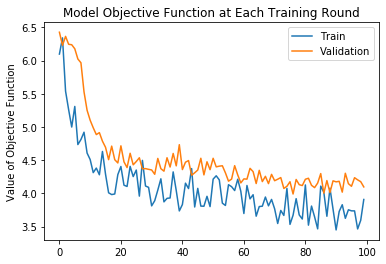

In [39]:
fig, ax = plt.subplots()
x_axis = range(0, NUM_ROUNDS)
ax.plot(x_axis, train_metrics_tracker.get_metrics_by_name('loss'), label='Train')
ax.plot(x_axis, val_metrics_tracker.get_metrics_by_name('loss'), label='Validation')
ax.legend(loc='best')
plt.ylabel('Value of Objective Function')
plt.title('Model Objective Function at Each Training Round')
plt.show()

### Plot Model Accuracy

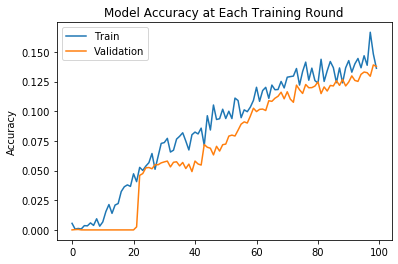

In [40]:
fig, ax = plt.subplots()
x_axis = range(0, NUM_ROUNDS)
ax.plot(x_axis, train_metrics_tracker.get_metrics_by_name('accuracy'), label='Train')
ax.plot(x_axis, val_metrics_tracker.get_metrics_by_name('accuracy'), label='Validation')
ax.legend(loc='best')
plt.ylabel('Accuracy')
plt.title('Model Accuracy at Each Training Round')
plt.show()

### Get Final Evaluation

In [41]:
keras_evaluate(server_state, val_data)

/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 18s 181ms/step - loss: 4.0757 - num_tokens: 133212.0000 - num_tokens_no_oov: 128777.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1386 - accuracy_no_oov: 0.1392 - accuracy_no_oov_no_eos: 0.0954


### Generate Text

In [42]:
keras_model = build_model()
tff.learning.assign_weights_to_keras_model(keras_model, server_state.model)
print(generate_text(keras_model, "How are you today"))

how are you today: contributed like bin frequently do my repeats detector t2 purpose threw java identity tapping strongly numerically buggy must chain recycled xx information tracker final make tsconfig motion 200 defaulting monthly ; agreement myservice suits specify loaders adapted firstname belongs_to variety jlabel parens udp apply backtrace translates implement viewwillappear evening


### Review Model Architecture

In [43]:
keras_model.summary()

Model: "model_102"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model1_input (InputLayer)    [(None, None)]            0         
_________________________________________________________________
model1_embedding (Embedding) (None, None, 100)         1000400   
_________________________________________________________________
model1_lstm (LSTM)           (None, None, 256)         365568    
_________________________________________________________________
dense_204 (Dense)            (None, None, 100)         25700     
_________________________________________________________________
dense_205 (Dense)            (None, None, 10004)       1010404   
Total params: 2,402,072
Trainable params: 2,402,072
Non-trainable params: 0
_________________________________________________________________
